### Building Footprint Detection and Damage Assessment from Satellite Images

This is part of the candidate selection process of Mckenzie Intelligence Services, see this [gitlab repo](https://gitlab.com/mckenzie-intelligence/recruiting/data/-/tree/main/Data%20Science/Building%20Footprint%20Detection%20and%20Damage%20Assessment?ref_type=heads) for details

#### Problem Statement
As a geospatial InsurTech firm, we manage extensive datasets of Satellite and Aerial Imagery.
One significant challenge we encounter involves the identification of building footprints within numerous images and the subsequent evaluation of their structural integrity.

#### Requirements
For this task, we require the development of a Computer Vision Model with the capability to perform the following:

1. Import satellite or aerial images from the designated data directory.
2. Conduct image preprocessing to optimize data quality.
3. Detect major types of objects such as buildings, cars or airplanes.
4. Employ detection techniques to identify the precise building footprints.
5. Generate a GeoJSON file containing polygon representations of the detected building footprints.
6. Create new images with the building footprints superimposed for visualization.
7. Obtain or generate tagged images of damaged buildings.
8. Determine the presence or absence of damage to the buildings.
9. Assess the degree of damage, categorizing it on a scale ranging from 'none' to 'low,' 'medium,' 'high,' or 'full.'

#### 1. Import image data

In [1]:
import os

Quicklook is a python package that I built for working with image data / numpy arrays. It is available through PyPI

In [2]:
#!pip install quicklook
from quicklook import quicklook 

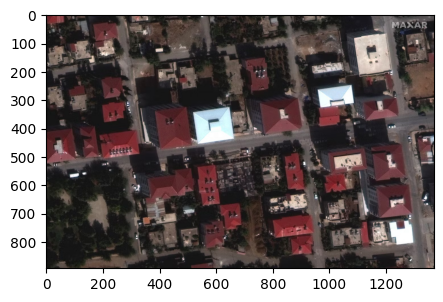

In [12]:
# define filepath
fpath = os.path.join('data','image_2.jpeg')

# load from file into numpy array
arr = quicklook.load(fpath)

# show numpy array
quicklook.show(arr)

#### 2. Image preprocessing

Quicklook comes with some preprocessing out of the box with quicklook, for details see the [source code](https://github.com/samsammurphy/quicklook/blob/main/quicklook/quicklook.py)


In [52]:
# replace array elements that are "not a number" with min valid number
arr = quicklook.replace_nan(arr)

# clip extreme pixel values
percentile = 2
arr = quicklook.percentile_clip(arr, percentile)

# scale pixels values to 0 - 255 and 8bit depth
arr = quicklook.bytescale(arr)

# (optionally) for machine learning scale between 0 and 1
arr = arr / 255

#### 3. Detect major types of objects

Detect buildings, cars, airplanes, etc. Here we are using [MMDetection](https://github.com/open-mmlab/mmdetection) and their pretrained pytorch model for general object detection from aerial images. Here are the [installation](https://mmdetection.readthedocs.io/en/latest/get_started.html) instructions.

In [6]:
input_filepath = 'data/image_6.jpeg'

# using their command line tool for quick demo
demo_cli = 'mmdetection/demo/image_demo.py'

# model config
config_file = '/Users/sam/code/footprints/models/rtmdet/large/rtmdet_x_8xb32-300e_coco.py'  

# model weights
checkpoint_file = '/Users/sam/code/footprints/models/rtmdet/large/rtmdet_x_8xb32-300e_coco_20220715_230555-cc79b9ae.pth' 

# bash command
command = f"python {demo_cli} {input_filepath} {config_file} --weights {checkpoint_file} --device cpu"

# Execute the command
get_ipython().system(command)


Loads checkpoint by local backend from path: /Users/sam/code/footprints/models/rtmdet/large/rtmdet_x_8xb32-300e_coco_20220715_230555-cc79b9ae.pth
11/15 13:27:26 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
/Users/sam/.pyenv/versions/3.10.0/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/Users/sam/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/functional.━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   
py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be require

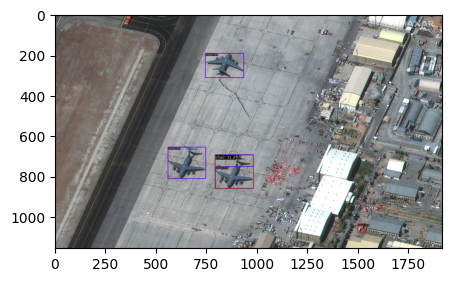

In [11]:
# visualize results
quicklook.show(quicklook.load('/Users/sam/code/footprints/outputs/vis/image_6.jpeg'))

This model ^ struggled with building footprints. Options to handle this..

1. try more models and compare performance
2. transfer learning of existing models with labelled data (if available)

#### Building footprints

Here were are using a second model that specializes in building footprint segmentation. Here is the [github repo](https://github.com/fuzailpalnak/building-footprint-segmentation/blob/main/examples/Prediction.ipynb)

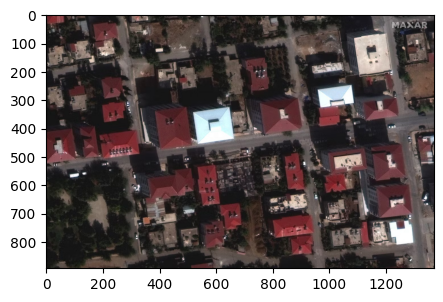

In [46]:
fpath = os.path.join('data','image_2.jpeg')
quicklook.show(quicklook.load(fpath))

In [47]:
import os.path
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils import model_zoo

#!pip install building-footprint-segmentation
from building_footprint_segmentation.seg.binary.models import ReFineNet
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import (
    to_input_image_tensor,
    add_extra_dimension,
    convert_tensor_to_numpy,
    load_parallel_model,
    adjust_model,
)
from building_footprint_segmentation.utils.operations import handle_image_size


In [48]:
MAX_SIZE = 512
TRAINED_MODEL = ReFineNet()
MODEL_URL = "https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/alpha/refine.zip"
PRED_PTH = fpath # r"path/to/input_image.png"

In [49]:
def set_model_weights():
    state_dict = model_zoo.load_url(MODEL_URL, progress=True, map_location="cpu")
    if "model" in state_dict:
        state_dict = state_dict["model"]
    TRAINED_MODEL.load_state_dict(adjust_model(state_dict))


def extract(original_image):
    original_height, original_width = original_image.shape[:2]

    if (original_height, original_width) != (MAX_SIZE, MAX_SIZE):
        original_image = handle_image_size(original_image, (MAX_SIZE, MAX_SIZE))

    # Apply Normalization
    normalized_image = min_max_image_net(img=original_image)

    tensor_image = add_extra_dimension(to_input_image_tensor(normalized_image))

    with torch.no_grad():
        # Perform prediction
        prediction = TRAINED_MODEL(tensor_image)
        prediction = prediction.sigmoid()

    prediction_binary = convert_tensor_to_numpy(prediction[0]).reshape(
        (MAX_SIZE, MAX_SIZE)
    )

    prediction_3_channels = cv2.cvtColor(prediction_binary, cv2.COLOR_GRAY2RGB)

    dst = cv2.addWeighted(
        original_image,
        1,
        (prediction_3_channels * (0, 255, 0)).astype(np.uint8),
        0.4,
        0,
    )
    return prediction_binary, prediction_3_channels, dst
    
def run(image_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    set_model_weights()
    # PARALLELIZE the model if gpu available
    # model = load_parallel_model(model)
    
    prediction_binary, prediction_3_channels, dst = extract(original_image)
    # imsave(f"{os.path.basename(image_path)}", prediction_binary)
    return prediction_binary, prediction_3_channels, dst

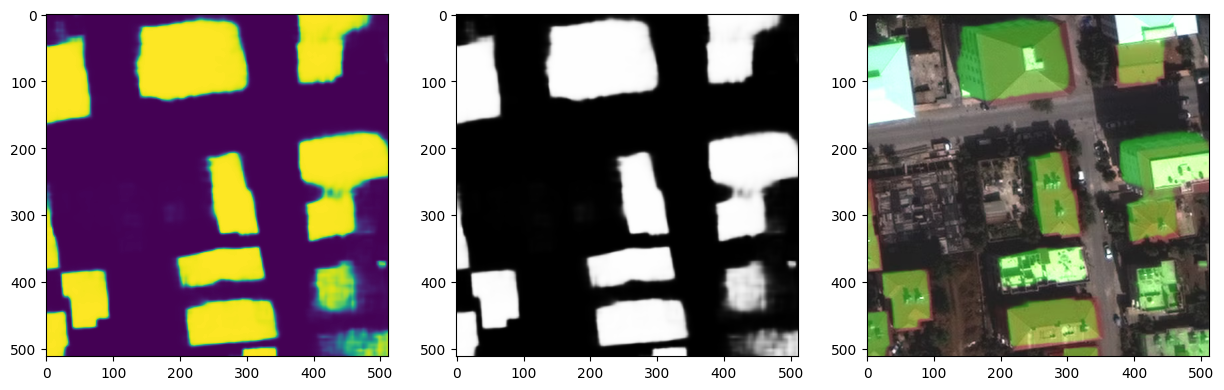

In [50]:
pred = run(PRED_PTH)

fig,ax = plt.subplots(1,3,figsize = (15,15))
ax = ax.ravel()
for i in range(3):
  image = pred[i]
  ax[i].imshow(image)  

plt.show()


#### GeoJson

The input data files are not rasters (i.e. georefenced images) instead they are .jpeg file format. This means any vectors (i.e. georeferenced shapes) extracted from them will not map onto the Earth's surface as we only have the pixel coordinates and not the coordinate reference system (CRS) needed to locate them geographically. However, if they were georeferenced images (e.g. GeoTiff) then one could use the Rasterio library to extract georeferenced shapes (i.e. shapely) which can then be saved to disk as geojson.

#### Damaged buildings 

**dataset**

An example dataset for damaged buildings is [Xview2](https://xview2.org/). Bonus, they apparently have $150,000 in cash awards available if you help them automate damage assessment.

**assessment**

Generally speaking there are three types of information we can use to classify images: spatial, spectral and temporal. For a typical CNN approach (e.g. U-net based architectures) we are using spatial (i.e. where things are located) and spectral (e.g. red,green,blue) information. However, I would recommend at least considering a temporal component to damage assessment (e.g. a before and after) to improve performance (especially to reduce confusion with buildings still under construction).